### Reading the dataset and importing libraries

In [1]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [2]:
# Basic libraries

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Libraries needed for NLP
import string, re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Libraries needed for modelling
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from wordcloud import WordCloud

In [3]:
messages = pd.read_csv('/kaggle/input/sms-classification2/spam_ham_classification.csv')
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5543,spam,This is the 2nd time we have tried 2 contact u...
5544,ham,Will ü b going to esplanade fr home?
5545,ham,"Pity, * was in mood for that. So...any other s..."
5546,ham,The guy did some bitching but I acted like i'd...


In [4]:
messages['length'] = messages['message'].apply(len)

In [5]:
messages

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5543,spam,This is the 2nd time we have tried 2 contact u...,160
5544,ham,Will ü b going to esplanade fr home?,36
5545,ham,"Pity, * was in mood for that. So...any other s...",57
5546,ham,The guy did some bitching but I acted like i'd...,125


### EDA

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

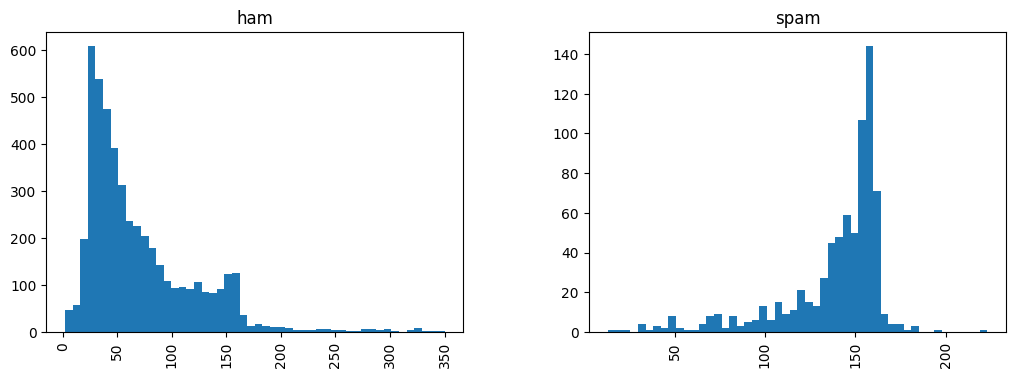

In [6]:
# Observe the length of messages by labels

messages.hist(column='length', by='label', bins=50, figsize=(12,4))
# We can observe that there are some outliers where length > 350 soo we need to deal with them

<Axes: xlabel='label', ylabel='count'>

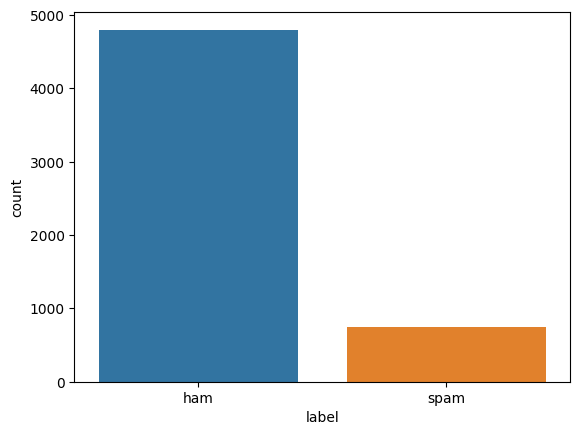

In [7]:
# Check the number of spam and non-spam messages

sns.countplot(x='label', data=messages)
# Dataset is imbalanced

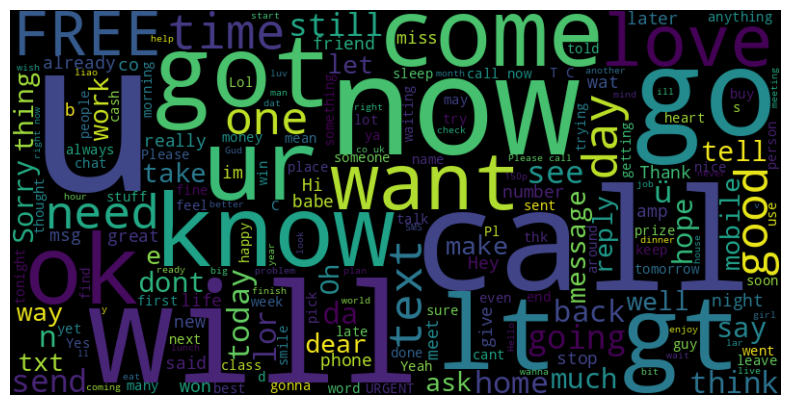

In [8]:
# Check the wordcloud to understand the messages and words that are frequently used

wordcloud = WordCloud(background_color='black', width=800, height=400).generate(''.join(messages.message))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Preprocessing and Tokenization

In [9]:
messages['length'].describe()

count    5548.000000
mean       78.744052
std        53.118276
min         2.000000
25%        35.000000
50%        61.000000
75%       121.000000
max       350.000000
Name: length, dtype: float64

In [10]:
# Remove outliers
drop_index = (messages[messages['length'] > 350]).index
messages.drop(drop_index, inplace=True, axis=0)

In [11]:
(messages[messages['length'] > 350]) 
# Outliers removed

,label,message,length


#### Now we need to [tokenize](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html#:~:text=These%20tokens%20are%20often%20loosely,useful%20semantic%20unit%20for%20processing.) the messages and convert it into a [bag-of-words](https://www.ibm.com/topics/bag-of-words) model.
To achieve this : <br>
We are going to remove punctuations, symbols, numbers ,[stop_words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), and finally [lemmatize](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html#2376) the text

In [12]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_symbols(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_numbers(text):
    result = ''.join(i for i in text if not i.isdigit())
    return result

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def preprocess_text(text):
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    #text = remove_numbers(text) for some reason when this is on multinomialNB fails to predict spam messages
    #text = remove_symbols(text)
    text = lemmatize_text(text)
    text = text.lower()
    return text

In [13]:
messages['cleaned'] = messages['message'].apply(preprocess_text)
messages

,label,message,length,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though
...,...,...,...,...
5543,spam,This is the 2nd time we have tried 2 contact u...,160,2nd time tried 2 contact u u £750 pound prize ...
5544,ham,Will ü b going to esplanade fr home?,36,ü b going esplanade fr home
5545,ham,"Pity, * was in mood for that. So...any other s...",57,pity mood suggestion
5546,ham,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...


### Vectorization

[Vectorization](https://neptune.ai/blog/vectorization-techniques-in-nlp-guidehttps://neptune.ai/blog/vectorization-techniques-in-nlp-guide) refers to the process of converting textual data into numerical representations that can be used for machine learning tasks. This involves representing textual data as vectors, matrices, or tensors that capture the semantic and syntactic information of the text.

- [Bag of Words (BoW)](https://www.geeksforgeeks.org/bag-of-words-bow-model-in-nlp/https://www.geeksforgeeks.org/bag-of-words-bow-model-in-nlp/): This is a simple and commonly used technique that represents text as a vector of word counts. It assigns a binary value (0 or 1) to each word in the vocabulary, indicating whether the word appears in the text or not.

- [TF-IDF (Term Frequency-Inverse Document Frequency)](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911ahttps://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a): TF-IDF is a weighting scheme that assigns higher weights to frequently occurring words that are also important across different documents. It takes into account the term frequency (how often a word appears in a document) and the inverse document frequency (how rare a word is across all documents).


In [14]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(analyzer=preprocess_text)),  
    ('tfidf_transformer', TfidfTransformer()),  
])

messages_tfidf = pipeline.fit_transform(messages['message'])
messages_tfidf

pipeline2 = Pipeline([
    ('count_vectorizer', CountVectorizer()),  
    ('tfidf_transformer', TfidfTransformer()),  
])

messages_tfidf2 = pipeline2.fit_transform(messages['message'])
messages_tfidf2

<5548x8602 sparse matrix of type '<class 'numpy.float64'>'
	with 72750 stored elements in Compressed Sparse Row format>

### Modelling

In [15]:
print('######################### Pipeline 1 - Preprocessesd ###############################')

X = messages_tfidf
y = messages['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))


rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print('######################### Pipeline 2 - Not preprocessesd ###############################')

X = messages_tfidf2
y = messages['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


######################### Pipeline 1 - Preprocessesd ###############################
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       943
           1       0.95      0.74      0.83       167

    accuracy                           0.95      1110
   macro avg       0.95      0.87      0.90      1110
weighted avg       0.95      0.95      0.95      1110

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       943
           1       0.98      0.86      0.92       167

    accuracy                           0.98      1110
   macro avg       0.98      0.93      0.95      1110
weighted avg       0.98      0.98      0.98      1110

######################### Pipeline 2 - Not preprocessesd ###############################
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       943
           1       1.00      0.66      0.80       167

    accu

#### Try out different algorithms and check how it affects the predictions and feel free to leave suggestions